# import packages

In [22]:
import tweepy
import yaml
import json
import sqlite3
from datetime import datetime
import pandas as pd
from collections import Counter
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.ticker import FuncFormatter

# Read twitter Authentication Keys

In [2]:
# yaml file reader funtion
def read_yaml(file_path):
    with open(file_path, "r") as f:
        return yaml.safe_load(f)

# yaml config file path
file_path = "twitter_api_key_config.yaml"
# read from config file
api_credential = read_yaml(file_path)

# Create Twitter Authentication

In [3]:
# API authentication
auth = tweepy.OAuthHandler(api_credential["api_key"], \
                           api_credential["api_secret_token"])
auth.set_access_token(api_credential["access_token"], \
                      api_credential["access_token_secret"])
api = tweepy.API(auth, wait_on_rate_limit=True)

# Create Database and Table

In [4]:
# establish a database connection
conn = sqlite3.connect('tweet_example_historic_v1.db')
cur = conn.cursor()
create_tweet_info_table = """CREATE TABLE tweet_info_historic_v1(tweet_id BIGINT PRIMARY KEY,\
                                          user_id BIGINT,\
                                          tweet_lang TEXT,\
                                          tweet_time TEXT,\
                                          source TEXT,\
                                          tweet_text TEXT,\
                                          quote_count TEXT,\
                                          reply_count INT,\
                                          retweet_count INT,\
                                          tweet_favorite_count INT,\
                                          hashtags TEXT,\
                                          short_urls TEXT,\
                                          expanded_urls TEXT,\
                                          user_mentions TEXT,\
                                          in_reply_to_user_id BIGINT,\
                                          in_reply_to_user_name TEXT,\
                                          in_reply_to_status_id BIGINT,\
                                          retweet_id BIGINT,\
                                          retweet_user_id BIGINT,\
                                          retweet_user_name TEXT,\
                                          quote_id BIGINT,\
                                          quote_user_id BIGINT,\
                                          quote_user_name TEXT);"""

create_user_info_table =  """CREATE TABLE user_info_historic_v1(user_id BIGINT PRIMARY KEY, \
                                          user_screen_name TEXT, \
                                          user_name TEXT, \
                                          user_language TEXT, \
                                          location TEXT, \
                                          profile_url TEXT, \
                                          description TEXT, \
                                          protected TEXT, \
                                          verified TEXT, \
                                          created_at TEXT, \
                                          friends_count BIGINT, \
                                          followers_count BIGINT,\
                                          favorites_count BIGINT, \
                                          statuses_count BIGINT);"""

cur.execute(create_tweet_info_table)
cur.execute(create_user_info_table)
conn.close()

# Collect historic Tweets

# Tweet explorer

In [5]:
class TweetExplorer:
    def __init__(self):
        pass
    def add_quote_content(self, tweet_content, quote_content, add_string=";"):
        if tweet_content and quote_content:
            added_content = tweet_content + add_string + quote_content
        elif not tweet_content and quote_content:
            added_content = quote_content
        elif tweet_content and not quote_content:
            added_content = tweet_content
        else:
            added_content = ""
        return added_content

    def get_text_entities(self, tweet_object):
        # tweet-text
        if "text" in tweet_object:
            tweet_text = tweet_object["text"]
        else:
            tweet_text = tweet_object["full_text"]
            
        # hashtags
        hashtags = [hashtag["text"] \
            for hashtag in tweet_object["entities"]["hashtags"]]
        hashtags = ";".join(hashtags) if hashtags else ""
        # user-mentions-id
        user_mentions_id = [x["id_str"] \
                            for x in tweet_object["entities"]["user_mentions"]]
        user_mentions_id = ";".join(user_mentions_id) if user_mentions_id else ""
        # user-mentions-name
        user_mentions_name = [x["screen_name"] \
                                     for x in tweet_object["entities"]["user_mentions"]]
        user_mentions_name = ";".join(user_mentions_name) if user_mentions_name else ""
        # short-urls
        short_urls = [x["url"] \
            for x in tweet_object["entities"]["urls"]]
        short_urls = ";".join(short_urls) if short_urls else ""
        # expanded-urls
        expanded_urls = [x["expanded_url"] \
            for x in tweet_object["entities"]["urls"]]
        expanded_urls = ";".join(expanded_urls) if expanded_urls else ""
        
        return tweet_text, hashtags,\
    user_mentions_id, user_mentions_name,\
    short_urls, expanded_urls

In [6]:
tweet_explorer = TweetExplorer()
class databaseManager:
    def __init__(self):
        self.unique_user_id_set = set([])
        self.conn = sqlite3.connect('tweet_example_historic_v1.db')
        self.cur  = self.conn.cursor()
    def insert_data(self, tweet_object):
        #tweet_object=json.loads(data) # convert "string-line" into json
        # check if json object has a key id. Otherwise continue to next.
        if 'id' in tweet_object.keys(): 
            
            # tweet object information
            tweet_id        = tweet_object['id']
            user_id         = tweet_object['user']['id']
            tweet_lang      = tweet_object['lang']
            tweet_time      = str(pd.to_datetime(tweet_object['created_at']))
            source          = tweet_object['source']


            # tweet numeric information
            #quote_count = tweet_object['quote_count']
            quote_count = 0
            reply_count = 0
            #reply_count = tweet_object['reply_count']
            retweet_count = tweet_object['retweet_count']
            tweet_favorite_count = tweet_object['favorite_count']


            # reply inofromation
            in_reply_to_user_id = tweet_object['in_reply_to_user_id']
            in_reply_to_user_name = tweet_object['in_reply_to_screen_name']
            in_reply_to_status_id = tweet_object['in_reply_to_status_id']

            ## complicated tweet-info collection
            is_retweet = False
            is_quote = False
        
            if "extended_tweet" in tweet_object.keys():
                tweet_content = tweet_object["extended_tweet"]
            else:
                tweet_content = tweet_object
                
            native_tweet_text,\
            native_hashtags,\
            native_user_mentions_id,\
            native_user_mentions_name,\
            native_short_urls,\
            native_expanded_urls = tweet_explorer.get_text_entities(tweet_content)

            # case: retweet 
            if "retweeted_status" in tweet_object:
                is_retweet = True
                # case: extended-retweet 
                if "extended_tweet" in tweet_object["retweeted_status"].keys():
                    retweet_content = tweet_object["retweeted_status"]["extended_tweet"]
                # case: not-extended-retweet 
                else:
                    retweet_content = tweet_object["retweeted_status"]

                retweet_tweet_text,\
                retweet_hashtags,\
                retweet_user_mentions_id,\
                retweet_user_mentions_name,\
                retweet_short_urls,\
                retweet_expanded_urls = tweet_explorer.get_text_entities(retweet_content)

            # case: quote-tweet
            if "quoted_status" in tweet_object:
                is_quote = True
                # case: extended-quote 
                if "extended_tweet" in tweet_object["quoted_status"].keys():
                    quote_content = tweet_object["quoted_status"]["extended_tweet"]
                else:
                    quote_content = tweet_object["quoted_status"]

                quote_tweet_text,\
                quote_hashtags,\
                quote_user_mentions_id,\
                quote_user_mentions_name,\
                quote_short_urls,\
                quote_expanded_urls = tweet_explorer.get_text_entities(quote_content)

            if is_retweet and is_quote:
                tweet_text = tweet_explorer.add_quote_content(retweet_tweet_text,\
                     quote_tweet_text, add_string=" ")
                hashtags = tweet_explorer.add_quote_content(retweet_hashtags,\
                     quote_hashtags)
                user_mentions_id = tweet_explorer.add_quote_content(native_user_mentions_id,\
                     quote_user_mentions_id)
                user_mentions_name = tweet_explorer.add_quote_content(native_user_mentions_name,\
                     quote_user_mentions_name)
                short_urls = tweet_explorer.add_quote_content(retweet_short_urls,\
                     quote_short_urls)
                expanded_urls = tweet_explorer.add_quote_content(retweet_expanded_urls,\
                     quote_expanded_urls)

            elif is_retweet and not is_quote:
                tweet_text = retweet_tweet_text
                hashtags = retweet_hashtags
                user_mentions_id = native_user_mentions_id
                user_mentions_name = native_user_mentions_name
                short_urls = retweet_short_urls
                expanded_urls = retweet_expanded_urls

            elif not is_retweet and is_quote:
                tweet_text = tweet_explorer.add_quote_content(native_tweet_text,\
                     quote_tweet_text, add_string=" ")
                hashtags = tweet_explorer.add_quote_content(native_hashtags,\
                     quote_hashtags)
                user_mentions_id = tweet_explorer.add_quote_content(native_user_mentions_id,\
                     quote_user_mentions_id)
                user_mentions_name = tweet_explorer.add_quote_content(native_user_mentions_name,\
                     quote_user_mentions_name)
                short_urls = tweet_explorer.add_quote_content(native_short_urls,\
                     quote_short_urls)
                expanded_urls = tweet_explorer.add_quote_content(native_expanded_urls,\
                     quote_expanded_urls)
            else:
                tweet_text = native_tweet_text #8
                hashtags = native_hashtags #9
                user_mentions_id = native_user_mentions_id #10
                user_mentions_name = native_user_mentions_name #11
                short_urls = native_short_urls #12
                expanded_urls = native_expanded_urls #13
                        
            # retweet and quote status case
            if is_retweet:
                retweet_id = tweet_object['retweeted_status']['id']
                retweet_user_id = tweet_object['retweeted_status']['user']['id']
                retweet_user_name = tweet_object['retweeted_status']['user']['screen_name']
            else:
                retweet_id = None
                retweet_user_id = None
                retweet_user_name = None

            if is_quote:
                quote_id = tweet_object['quoted_status']['id']
                quote_user_id = tweet_object['quoted_status']['user']['id']
                quote_user_name = tweet_object['quoted_status']['user']['screen_name']
            else:
                quote_id = None
                quote_user_id = None
                quote_user_name = None
            
            tweet_info = (tweet_id, user_id, tweet_lang,\
                    tweet_time, source, tweet_text,\
                    quote_count, reply_count, retweet_count,\
                    tweet_favorite_count, hashtags, short_urls,\
                    expanded_urls, user_mentions_id,\
                    in_reply_to_user_id, in_reply_to_user_name,\
                    in_reply_to_status_id, retweet_id,\
                    retweet_user_id, retweet_user_name,\
                    quote_id, quote_user_id,\
                    quote_user_name)
            self.cur.execute("INSERT INTO tweet_info_historic_v1 \
            VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,\
             ?, ?, ?, ?, ?, ?, ?, ?, ?);", tweet_info)
            
            # user profile information

            if user_id in self.unique_user_id_set:
                pass
            else:
                self.unique_user_id_set.add(user_id)
                
                user_screen_name      = tweet_object['user']['screen_name']
                user_name             = tweet_object['user']['name']
                user_language         = tweet_object['user']['lang']  
                location              = tweet_object['user']['location']
                profile_url           = tweet_object['user']['url']
                description           = tweet_object['user']['description']
                protected             = tweet_object['user']['protected']
                verified              = tweet_object['user']['verified']
                created_at            = str(pd.to_datetime(tweet_object['user']['created_at']))
                friends_count         = tweet_object['user']['friends_count']
                followers_count       = tweet_object['user']['followers_count']
                favorites_count       = tweet_object['user']['favourites_count']
                statuses_count        = tweet_object['user']['statuses_count']

                user_information = (user_id, user_screen_name, user_name,\
                       user_language, location, profile_url,\
                       description, protected, verified, created_at,\
                       friends_count, followers_count,\
                       favorites_count, statuses_count)
                self.cur.execute(" INSERT INTO user_info_historic_v1 VALUES(?, ?, ?, ?, ?, ?, ?, ?,\
                ?, ?, ?, ?, ?, ?);", user_information)
            
            self.conn.commit()
    def close_database_connection(self):
        self.conn.close()

# Search Tweets
https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/overview

# Rules and Filtering
https://developer.twitter.com/en/docs/twitter-api/v1/rules-and-filtering/build-standard-queries

# Collect all availble historic tweets in the last seven days

In [ ]:
all_historic_tweets = []
for historic_tweets in tweepy.Cursor(api.search, q="covid", count=100).items():
    all_historic_tweets.append(historic_tweets)

In [ ]:
len(all_historic_tweets)

In [7]:
historic_tweet_collection = []
upper_limit = 2000
histroic_tweet_count = 0
dbm = databaseManager()
historic_tweet_count = 0
search_query = "covid"
location = "35.0853336,-106.6055534,100km"
for tweet in tweepy.Cursor(api.search, \
                                     q=search_query, \
                                     geocode=location,\
                                     count=100).items():
    dbm.insert_data(tweet._json)
    historic_tweet_count += 1
    print(f"historic_tweet_count: {historic_tweet_count}")
    if historic_tweet_count > upper_limit:
        break
        
print(historic_tweet_count)

dbm.close_database_connection()

historic_tweet_count: 1
historic_tweet_count: 2
historic_tweet_count: 3
historic_tweet_count: 4
historic_tweet_count: 5
historic_tweet_count: 6
historic_tweet_count: 7
historic_tweet_count: 8
historic_tweet_count: 9
historic_tweet_count: 10
historic_tweet_count: 11
historic_tweet_count: 12
historic_tweet_count: 13
historic_tweet_count: 14
historic_tweet_count: 15
historic_tweet_count: 16
historic_tweet_count: 17
historic_tweet_count: 18
historic_tweet_count: 19
historic_tweet_count: 20
historic_tweet_count: 21
historic_tweet_count: 22
historic_tweet_count: 23
historic_tweet_count: 24
historic_tweet_count: 25
historic_tweet_count: 26
historic_tweet_count: 27
historic_tweet_count: 28
historic_tweet_count: 29
historic_tweet_count: 30
historic_tweet_count: 31
historic_tweet_count: 32
historic_tweet_count: 33
historic_tweet_count: 34
historic_tweet_count: 35
historic_tweet_count: 36
historic_tweet_count: 37
historic_tweet_count: 38
historic_tweet_count: 39
historic_tweet_count: 40
historic_

historic_tweet_count: 395
historic_tweet_count: 396
historic_tweet_count: 397
historic_tweet_count: 398
historic_tweet_count: 399
historic_tweet_count: 400
historic_tweet_count: 401
historic_tweet_count: 402
historic_tweet_count: 403
historic_tweet_count: 404
historic_tweet_count: 405
historic_tweet_count: 406
historic_tweet_count: 407
historic_tweet_count: 408
historic_tweet_count: 409
historic_tweet_count: 410
historic_tweet_count: 411
historic_tweet_count: 412
historic_tweet_count: 413
historic_tweet_count: 414
historic_tweet_count: 415
historic_tweet_count: 416
historic_tweet_count: 417
historic_tweet_count: 418
historic_tweet_count: 419
historic_tweet_count: 420
historic_tweet_count: 421
historic_tweet_count: 422
historic_tweet_count: 423
historic_tweet_count: 424
historic_tweet_count: 425
historic_tweet_count: 426
historic_tweet_count: 427
historic_tweet_count: 428
historic_tweet_count: 429
historic_tweet_count: 430
historic_tweet_count: 431
historic_tweet_count: 432
historic_twe

historic_tweet_count: 800
historic_tweet_count: 801
historic_tweet_count: 802
historic_tweet_count: 803
historic_tweet_count: 804
historic_tweet_count: 805
historic_tweet_count: 806
historic_tweet_count: 807
historic_tweet_count: 808
historic_tweet_count: 809
historic_tweet_count: 810
historic_tweet_count: 811
historic_tweet_count: 812
historic_tweet_count: 813
historic_tweet_count: 814
historic_tweet_count: 815
historic_tweet_count: 816
historic_tweet_count: 817
historic_tweet_count: 818
historic_tweet_count: 819
historic_tweet_count: 820
historic_tweet_count: 821
historic_tweet_count: 822
historic_tweet_count: 823
historic_tweet_count: 824
historic_tweet_count: 825
historic_tweet_count: 826
historic_tweet_count: 827
historic_tweet_count: 828
historic_tweet_count: 829
historic_tweet_count: 830
historic_tweet_count: 831
historic_tweet_count: 832
historic_tweet_count: 833
historic_tweet_count: 834
historic_tweet_count: 835
historic_tweet_count: 836
historic_tweet_count: 837
historic_twe

historic_tweet_count: 1199
historic_tweet_count: 1200
historic_tweet_count: 1201
historic_tweet_count: 1202
historic_tweet_count: 1203
historic_tweet_count: 1204
historic_tweet_count: 1205
historic_tweet_count: 1206
historic_tweet_count: 1207
historic_tweet_count: 1208
historic_tweet_count: 1209
historic_tweet_count: 1210
historic_tweet_count: 1211
historic_tweet_count: 1212
historic_tweet_count: 1213
historic_tweet_count: 1214
historic_tweet_count: 1215
historic_tweet_count: 1216
historic_tweet_count: 1217
historic_tweet_count: 1218
historic_tweet_count: 1219
historic_tweet_count: 1220
historic_tweet_count: 1221
historic_tweet_count: 1222
historic_tweet_count: 1223
historic_tweet_count: 1224
historic_tweet_count: 1225
historic_tweet_count: 1226
historic_tweet_count: 1227
historic_tweet_count: 1228
historic_tweet_count: 1229
historic_tweet_count: 1230
historic_tweet_count: 1231
historic_tweet_count: 1232
historic_tweet_count: 1233
historic_tweet_count: 1234
historic_tweet_count: 1235
h

# Get histroic tweets into dataframe

In [10]:
conn = sqlite3.connect('tweet_example_historic_v1.db')
cur  = conn.cursor()

In [11]:
cur.execute("SELECT * FROM tweet_info_historic_v1")
tweet_info_all_result = cur.fetchall()
tweet_info_column_names = [description[0] for description in cur.description]
tweet_info_dataframe = pd.DataFrame(tweet_info_all_result, \
                                   columns=tweet_info_column_names)
print(f"No of tweet stored: {len(tweet_info_all_result)}, {tweet_info_dataframe.shape[0]}\n")



cur.execute("SELECT * FROM user_info_historic_v1")
user_info_all_result = cur.fetchall()
user_info_column_names = [description[0] for description in cur.description]
user_info_dataframe = pd.DataFrame(user_info_all_result, \
                                   columns=user_info_column_names)
print(f"No of user info stored: {len(user_info_all_result)}, {user_info_dataframe.shape[0]}\n")

No of tweet stored: 1485, 1485

No of user info stored: 626, 626



In [35]:
user_info_dataframe.head()

,user_id,user_screen_name,user_name,user_language,location,profile_url,description,protected,verified,created_at,friends_count,followers_count,favorites_count,statuses_count,datetime
0,23341160,ConsiderThis1,Karen Kline,None,"Santa Fe, New Mexico",https://t.co/si4IMQ3NEp,A tall old blonde taking a stand against corru...,0,0,2009-03-08 19:06:55+00:00,11102,12621,3815,445221,2009-03-08 19:06:55+00:00
1,1220034889879187456,AlisaValdesRod1,Author Alisa Valdés,None,"Albuquerque, NM",https://t.co/VXATvKbtOW,NY Times bestselling novelist & screenwriter. ...,0,0,2020-01-22 17:26:24+00:00,108,5864,10856,3934,2020-01-22 17:26:24+00:00
2,6842112,koat7news,KOAT.com,None,"Albuquerque, NM, USA",https://t.co/vneFJyOx7S,Breaking news and real-time updates for New Me...,0,1,2007-06-15 21:10:32+00:00,364,106338,6449,193785,2007-06-15 21:10:32+00:00
3,804329083,pixchips,HaplessMaskedUnfluencer😡😷,None,"Santa Fe, NM.",None,Fully vaccinated. Still wear mask if in crowd....,0,0,2012-09-05 10:33:23+00:00,3089,1586,8528,59909,2012-09-05 10:33:23+00:00
4,892937672213225472,mozbun1,Michelle Adair Ozbun #BlackLivesMatter,None,"Albuquerque, NM",None,"Feminist, Scientist @ozbunHPVlab, Mother of dr...",0,0,2017-08-03 02:38:25+00:00,475,297,1561,1472,2017-08-03 02:38:25+00:00


In [15]:
if 'datetime' not in tweet_info_dataframe.columns:
    tweet_info_dataframe["datetime"] = pd.to_datetime(tweet_info_dataframe["tweet_time"])
    
if 'datetime' not in user_info_dataframe.columns:
    user_info_dataframe["datetime"] = pd.to_datetime(user_info_dataframe["created_at"])

In [50]:
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk import FreqDist
from nltk.util import ngrams
import matplotlib.pyplot as plt
import re
import string

In [52]:
cur.execute("SELECT tweet_text FROM tweet_info_historic_v1")
all_tweet_text = cur.fetchall()
all_tweet_list=[x[0] for x in all_tweet_text]


warnings.filterwarnings("ignore")

punctuation = [x for x in string.punctuation]
stop_words = stopwords.words('english') + punctuation + ['rt', 'via',"i'm","don't"]

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'

tokenizer = TweetTokenizer()

def tweet_tokenizer(verbatim):
    try:
        stripped = re.sub(combined_pat, '', verbatim)
        stripped = re.sub(www_pat, '', stripped)
        lower_case = stripped.lower()
        letters_only = re.sub("[^a-zA-Z]", " ", lower_case)
    
        all_tokens = tokenizer.tokenize(letters_only)
        
        # this line filters out all tokens that are entirely non-alphabetic characters
        filtered_tokens = [t for t in all_tokens if t.islower()]
        # filter out all tokens that are <2 chars
        filtered_tokens = [x for x in filtered_tokens if len(x)>1]
        
        filtered_tokens = [term for term in filtered_tokens if term not in stop_words]
        
        out_text=' '.join(filtered_tokens)
    except IndexError:
        out_text=''
        filtered_tokens = []
    return(out_text)
    

test_bed = [tweet_tokenizer(x) for x in all_tweet_list]
all_concat_str = ' '.join(test_bed)
#freq_dist_count=FreqDist(ngrams(all_concat_str.split(), 2))                  
freq_dist_count = FreqDist(all_concat_str.split())   
"""
to_WC = freq_dist_count.most_common(100)
wordcloud_purged = WordCloud(max_font_size=120, max_words=100, background_color="white",\
                      width=800, height=600)\
                      .generate_from_frequencies(dict(to_WC))

plt.figure()
plt.imshow(wordcloud_purged, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud_purged.to_file("WC_BIGRAM_LIB_NEG_T100.png")     
"""
a= 3

In [53]:
freq_dist_count

FreqDist({'covid': 1004, 'people': 142, 'new': 135, 'get': 114, 'vaccine': 113, 'vaccinated': 85, 'cases': 68, 'one': 64, 'mexico': 63, 'like': 60, ...})

In [16]:
tweet_info_dataframe.head()

,tweet_id,user_id,tweet_lang,tweet_time,source,tweet_text,quote_count,reply_count,retweet_count,tweet_favorite_count,...,in_reply_to_user_id,in_reply_to_user_name,in_reply_to_status_id,retweet_id,retweet_user_id,retweet_user_name,quote_id,quote_user_id,quote_user_name,datetime
0,1438532979605729299,23341160,en,2021-09-16 15:59:23+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",@Stathies I saw something like that yesterday....,0,0,0,0,...,191567917.0,Stathies,1.438530e+18,None,None,None,1.438289e+18,1.248377e+18,RobertApter1,2021-09-16 15:59:23+00:00
1,1438531435648933890,1220034889879187456,en,2021-09-16 15:53:15+00:00,"<a href=""http://twitter.com/download/android"" ...",1 in 500 Americans have died of covid. No othe...,0,0,0,2,...,NaN,None,NaN,None,None,None,NaN,NaN,None,2021-09-16 15:53:15+00:00
2,1438529905894072329,6842112,en,2021-09-16 15:47:10+00:00,"<a href=""http://www.socialnewsdesk.com"" rel=""n...",South Florida landlord requires new tenants an...,0,0,2,0,...,NaN,None,NaN,None,None,None,NaN,NaN,None,2021-09-16 15:47:10+00:00
3,1438528675259904004,804329083,en,2021-09-16 15:42:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",@MedicVet68 Found this: https://t.co/SDMR5Uurf...,0,0,0,1,...,804329083.0,pixchips,1.438527e+18,None,None,None,NaN,NaN,None,2021-09-16 15:42:17+00:00
4,1438526659305476098,892937672213225472,en,2021-09-16 15:34:16+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Our own @ChackLab vaccinologist Bryce Chackeri...,0,0,0,0,...,NaN,None,NaN,None,None,None,NaN,NaN,None,2021-09-16 15:34:16+00:00


In [42]:
def get_median_frequency(df, key, frequency='W',\
                        start_date='2009-01-01', end_date='2021-09-20'):
    
    df = df[[key, 'datetime']].drop_duplicates() 
    counts_month = df[[key, 'datetime']].groupby(pd.Grouper(key='datetime', freq=frequency)).median()
    
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq=frequency)
    counts_month = counts_month.reindex(idx, fill_value=0)
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    
    return counts_month

def get_mean_frequency(df, key, frequency='W',\
                        start_date='2009-01-01', end_date='2021-09-20'):
    
    df = df[[key, 'datetime']].drop_duplicates() 
    counts_month = df[[key, 'datetime']].groupby(pd.Grouper(key='datetime', freq=frequency)).mean()
    
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq=frequency)
    counts_month = counts_month.reindex(idx, fill_value=0)
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    
    return counts_month

def get_count_frequency(df, key, frequency='M',\
                        start_date='2009-01-01', end_date='2021-09-01'):
    
    #df = df[[key, 'datetime']].drop_duplicates() 
    counts_month = df[[key, 'datetime']].groupby(pd.Grouper(key='datetime', freq=frequency)).count()
    print(counts_month)
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq=frequency)
    counts_month = counts_month.reindex(idx, fill_value=0)
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    
    return counts_month

In [24]:
def plot_frequency_counts_2(count_dfs, key, path, y_label, x_label, leg):
    
    count_df = count_dfs[0]
    second   = count_dfs[1]
    counts_2 = second[key].tolist()
    counts   = count_df[key].tolist()
    index    = count_df.index.date.tolist()

    days = [datetime.strptime(x.strftime('%d-%m-%Y'), '%d-%m-%Y') for x in index]
    days2 = mdates.date2num(days)
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot_date(days2, counts, marker= ',',linestyle='--', color='red')
    ax.plot_date(days2, counts_2, marker= ',',linestyle=':',color='blue')
    

    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")     
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()

    fig.autofmt_xdate()
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    #plt.grid()
    plt.xticks(rotation=40)
    plt.legend(leg, loc='best', fontsize=13)
    plt.margins(x=0)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    plt.savefig(path, bbox_inches='tight')

In [25]:
def plot_frequency_counts_double(count_dfs, key, path, y_label, x_label, leg):
    
    count_df = count_dfs[0]
    
    counts   = count_df[key[0]].tolist()
    index    = count_df.index.date.tolist()
    second   = count_dfs[1]
    counts_2 = second[key[1]].tolist()

    days = [datetime.strptime(x.strftime('%d-%m-%Y'), '%d-%m-%Y') for x in index]
    days2 = mdates.date2num(days)
    fig, ax = plt.subplots(figsize=(12,4))
    ax2 = ax.twinx()
    
    ax.plot_date(days2, counts, marker= ',',linestyle='--', label = 'status', color='red')
    ax2.plot_date(days2, counts_2, marker= ',',linestyle=':',  label = 'friend',color='blue')
    

    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")     
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()
    
    fig.autofmt_xdate()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label[0], color='red')
    ax2.set_ylabel(y_label[1], color='blue')
    ax.tick_params(axis='y', labelcolor='red')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax.tick_params(axis='x', rotation=45)
    #plt.grid()
    #plt.xticks(rotation=50)

    ax.legend(loc= 3,fontsize=13)
    ax2.legend(loc=1,fontsize=13)
    #ax2.legend('friend', loc=0, fontsize=13)
    plt.margins(x=0)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    plt.savefig(path, bbox_inches='tight')

In [33]:
def plot_frequency_counts_1(count_df, key, path, y_label, x_label, leg):
    

    counts   = count_df[key].tolist()
    index    = count_df.index.date.tolist()

    days = [datetime.strptime(x.strftime('%d-%m-%Y'), '%d-%m-%Y') for x in index]
    days2 = mdates.date2num(days)
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot_date(days2, counts, marker= ',',linestyle='--')
    

    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")     
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()

    fig.autofmt_xdate()
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.grid()
    plt.xticks(rotation=40)
    plt.legend(leg, loc='best', fontsize=13)
    plt.margins(x=0)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
    plt.savefig(path, bbox_inches='tight')   

In [37]:
user_info_dataframe

,user_id,user_screen_name,user_name,user_language,location,profile_url,description,protected,verified,created_at,friends_count,followers_count,favorites_count,statuses_count,datetime
0,23341160,ConsiderThis1,Karen Kline,None,"Santa Fe, New Mexico",https://t.co/si4IMQ3NEp,A tall old blonde taking a stand against corru...,0,0,2009-03-08 19:06:55+00:00,11102,12621,3815,445221,2009-03-08 19:06:55+00:00
1,1220034889879187456,AlisaValdesRod1,Author Alisa Valdés,None,"Albuquerque, NM",https://t.co/VXATvKbtOW,NY Times bestselling novelist & screenwriter. ...,0,0,2020-01-22 17:26:24+00:00,108,5864,10856,3934,2020-01-22 17:26:24+00:00
2,6842112,koat7news,KOAT.com,None,"Albuquerque, NM, USA",https://t.co/vneFJyOx7S,Breaking news and real-time updates for New Me...,0,1,2007-06-15 21:10:32+00:00,364,106338,6449,193785,2007-06-15 21:10:32+00:00
3,804329083,pixchips,HaplessMaskedUnfluencer😡😷,None,"Santa Fe, NM.",None,Fully vaccinated. Still wear mask if in crowd....,0,0,2012-09-05 10:33:23+00:00,3089,1586,8528,59909,2012-09-05 10:33:23+00:00
4,892937672213225472,mozbun1,Michelle Adair Ozbun #BlackLivesMatter,None,"Albuquerque, NM",None,"Feminist, Scientist @ozbunHPVlab, Mother of dr...",0,0,2017-08-03 02:38:25+00:00,475,297,1561,1472,2017-08-03 02:38:25+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,2175966496,el_negro_pe,Negro Pé,None,El País de las Maravillas,https://t.co/Wv9prRtEma,📷 Instagram: @el_negro_pe,0,0,2013-11-10 17:12:11+00:00,252,146,463,917,2013-11-10 17:12:11+00:00
622,119273882,BarbaraMulvaney,Barbara Mulvaney,None,"Santa Fe, NM",None,,0,0,2010-03-03 04:39:40+00:00,3353,995,2491,4095,2010-03-03 04:39:40+00:00
623,151903568,JonMertz,Jon Mertz,None,"Santa Fe, New Mexico",https://t.co/i47QeEXcjv,Thought Entrepreneur - Exploring the intersect...,0,0,2010-06-04 15:02:06+00:00,26744,46713,26610,88811,2010-06-04 15:02:06+00:00
624,48094399,BFrei46,Bryan,None,"Albuquerque, NM",https://t.co/smYVsujs7J,"A far-off, yet aspiring phlogiston...or philol...",0,0,2009-06-17 20:04:19+00:00,642,243,10716,15988,2009-06-17 20:04:19+00:00


                           user_id
datetime                          
2006-12-31 00:00:00+00:00        1
2007-01-31 00:00:00+00:00        0
2007-02-28 00:00:00+00:00        0
2007-03-31 00:00:00+00:00        1
2007-04-30 00:00:00+00:00        0
...                            ...
2021-05-31 00:00:00+00:00       10
2021-06-30 00:00:00+00:00        2
2021-07-31 00:00:00+00:00        5
2021-08-31 00:00:00+00:00        9
2021-09-30 00:00:00+00:00        2

[178 rows x 1 columns]


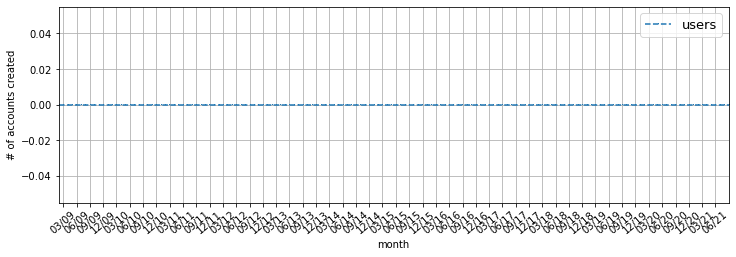

In [43]:
created_per_unit = get_count_frequency(user_info_dataframe,\
                                       key='user_id', frequency='M')


plot_frequency_counts_1(created_per_unit,\
                       key="user_id", path='account_created_unit.pdf',\
                       y_label='# of accounts created',\
                       x_label='month',\
                       leg=['users'])  

In [40]:
created_per_unit

,user_id
2009-01-31,0
2009-02-28,0
2009-03-31,0
2009-04-30,0
2009-05-31,0
...,...
2021-04-30,0
2021-05-31,0
2021-06-30,0
2021-07-31,0


In [41]:
user_info_dataframe.shape

(626, 15)

In [30]:
created_per_unit

,user_id
2009-12-31,0
2010-12-31,0
2011-12-31,0
2012-12-31,0
2013-12-31,0
2014-12-31,0
2015-12-31,0
2016-12-31,0
2017-12-31,0
2018-12-31,0


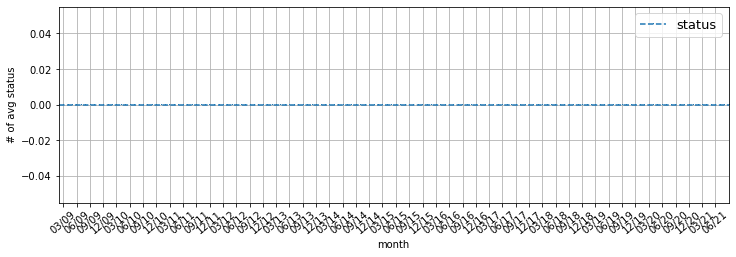

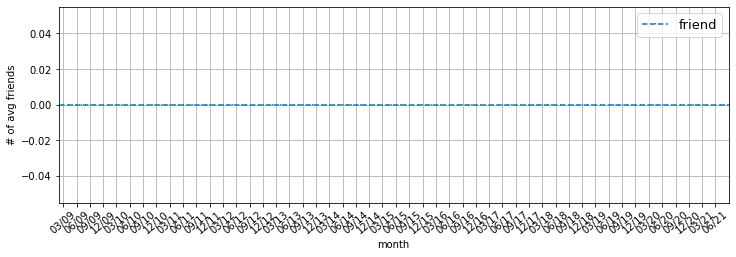

In [28]:
status_month = get_mean_frequency(user_info_dataframe, key='statuses_count', frequency='M')
plot_frequency_counts_1(status_month,\
                       key="statuses_count", path='status_week.pdf',
                       y_label='# of avg status', x_label='month',\
                       leg=['status'])  

friends_month = get_mean_frequency(user_info_dataframe, key='friends_count', frequency='M')
plot_frequency_counts_1(friends_month,\
                       key="friends_count", path='friends_week.pdf',\
                       y_label='# of avg friends', x_label='month',\
                       leg=['friend'])



In [ ]:
dbm.close_database_connection()

In [ ]:

dbm.close_database_connection()

In [ ]:
tweet

In [66]:

pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [67]:
import networkx as nx

In [70]:
pip install decorator==5.0.7

  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.6
    Uninstalling decorator-5.0.6:
      Successfully uninstalled decorator-5.0.6
Note: you may need to restart the kernel to use updated packages.


In [68]:
G = nx.Graph()

NetworkXError: random_state_index is incorrect

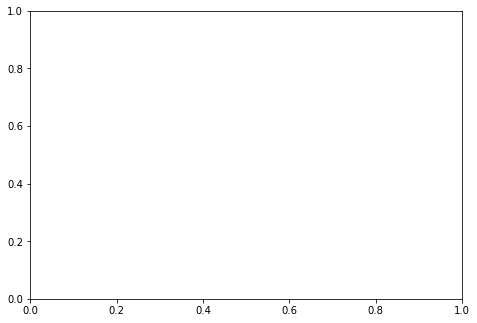

In [69]:
G = nx.Graph()
G.add_nodes_from([1,2,3])
G.add_edges_from([(1, 2), (1, 3)])
nx.draw(G)